<a href="https://colab.research.google.com/github/V4lciJr/Redes-Neurais-Classificacao-de-Dedos/blob/main/Redes_Neurais_Classifica%C3%A7%C3%A3o_de_Dedos_das_M%C3%A3os.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neurais

Este é um exemplo de como podemos usar as redes neurais para uma tarefa de classificação, o problema consiste em passar imagens de mãos, que indicam números de 0 a 5, e a rede após o treinamento e teste, nos dizer que número aquela mão está representando.
O dataset consiste em um conjunto de imagens classificadas em 6 classes de 0 a 1, dividiremos esse conjunto em treino e teste e no final na parte da inferência, utilizaremos imagens que não fazem parte do conjunto, para certificarmos que o nosso modelo está classificando as imagens corretamente.**negrito**

In [ ]:
# Montando o drive que será usado

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Mounted at /content/drive


Saving test_signs.h5 to test_signs (1).h5
Saving train_signs.h5 to train_signs (1).h5
User uploaded file "test_signs (1).h5" with length 1477712 bytes
User uploaded file "train_signs (1).h5" with length 13281872 bytes


## Importando as Bibliotecas necessárias

In [ ]:
import keras
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras import layers, datasets, models

keras.backend.clear_session()

O comando keras.backend.clear_session() é usado para liberar os recursos de memória associados ao backend do Keras, como os grafos computacionais, e reiniciar o estado global do TensorFlow.

Esse comando é útil em situações como:

* **Evitar acumulação de memória:** Em scripts ou notebooks interativos, ao treinar múltiplos modelos em sequência, ele evita que os grafos de modelos anteriores ocupem espaço desnecessário.
* **Evitar conflitos entre modelos:** Garantir que o estado de um modelo não interfira no treinamento ou avaliação de outro modelo.

É recomendado usar esse comando após finalizar um modelo e antes de iniciar outro.

In [ ]:
# cnoversão para one_hot

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

# extraindo os conjuntos

def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

# carregando o conjunto de exmeplos

train_images, train_labels, test_images, test_labels, classes = load_dataset()

y = 5


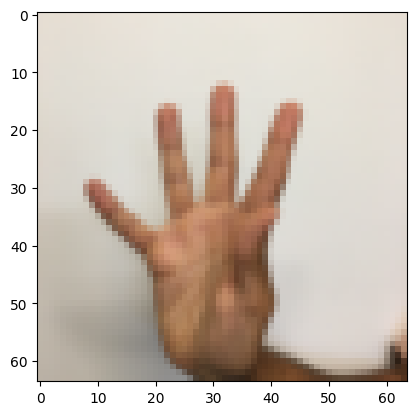

In [ ]:
# pegando um exemplo

index = 12
plt.imshow(train_images[index])
print ("y = " + str(np.squeeze(train_labels[:, index])))

In [ ]:
train_images = train_images / 255.    # normalização para range [0..1] -> RGB é de [0..255]
test_images = test_images / 255.      # normalização para range [0..1] -> RGB é de [0..255]
train_labels = convert_to_one_hot(train_labels, 6).T
test_labels = convert_to_one_hot(test_labels, 6).T
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)


# verificando as dimensões dos conjuntos de entrada

print("number of training examples = " + str(train_images.shape[0]))
print("number of test examples = " + str(test_images.shape[0]))
print("train_images shape" + str(train_images.shape))
print("train_labels shape" + str(train_labels.shape))
print("test_images shape" + str(test_images.shape))
print("test_labels shape" + str(test_labels.shape))

number of training examples = 1080
number of test examples = 120
train_images shape(1080, 64, 64, 3)
train_labels shape(1080,)
test_images shape(120, 64, 64, 3)
test_labels shape(120,)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         589,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 646,598 (2.47 MB)

 Trainable params: 646,598 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

## Realizando o treinamento e validação da rede

Otimizador, usaremos o Adam

Função Custo = SparseCategoricalCrossentropy

Número de épocas = 10

Tamanho do minibatch -> batch_size = None (sem utilização de minibatch)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, batch_size=None,
                    validation_data=(test_images, test_labels))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 274ms/step - accuracy: 0.1989 - loss: 1.7948 - val_accuracy: 0.3417 - val_loss: 1.6279
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 340ms/step - accuracy: 0.4757 - loss: 1.4248 - val_accuracy: 0.6333 - val_loss: 1.0825
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 261ms/step - accuracy: 0.6530 - loss: 0.9740 - val_accuracy: 0.7417 - val_loss: 0.7912
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.7674 - loss: 0.6678 - val_accuracy: 0.7917 - val_loss: 0.6176
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - accuracy: 0.8107 - loss: 0.5722 - val_accuracy: 0.8167 - val_loss: 0.5005
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.8688 - loss: 0.4109 - val_accuracy: 0.8417 - val_loss: 0.4050
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.8865 - loss: 0.3222 - val_accuracy: 0.8583 - val_loss: 0.3442
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 236ms/step - accuracy: 0.8977 - loss: 0.3358 - val_accuracy: 0.8583 - 

## Gráfico de Acurácia para o conjunto de treinamento e validação

4/4 - 0s - 51ms/step - accuracy: 0.9167 - loss: 0.2602


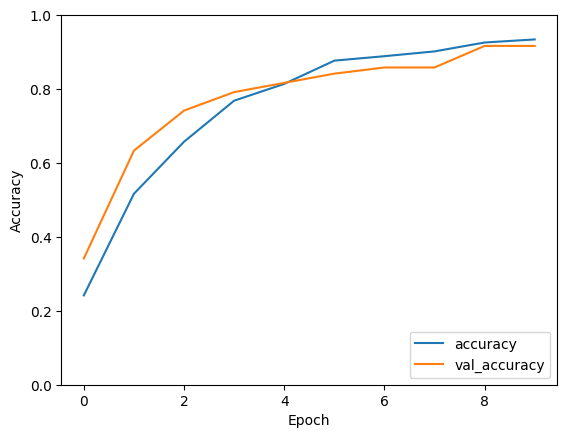

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

## Gráfico da Função Custo

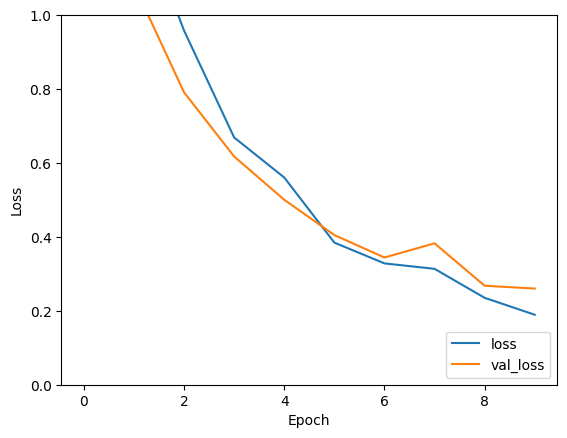

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')


# Testando um modelo para uma imagem qualquer



In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving cincoEu - Copia.jpeg to cincoEu - Copia (1).jpeg
Saving cincoEu.jpeg to cincoEu (1).jpeg
Saving cincoJocy - Copia.jpeg to cincoJocy - Copia (1).jpeg
Saving cincoJocy.jpeg to cincoJocy (1).jpeg
Saving dedo01.jpeg to dedo01 (1).jpeg
Saving doisJocy.jpeg to doisJocy (1).jpeg
Saving quatroJocy.jpeg to quatroJocy (1).jpeg
Saving quatroNovoJocy.jpeg to quatroNovoJocy (1).jpeg
Saving tresEu.jpeg to tresEu (1).jpeg
Saving tresJocy.jpeg to tresJocy (1).jpeg
Saving umEu.jpeg to umEu (1).jpeg
Saving umJocy.jpeg to umJocy (1).jpeg
User uploaded file "cincoEu - Copia (1).jpeg" with length 51696 bytes
User uploaded file "cincoEu (1).jpeg" with length 51696 bytes
User uploaded file "cincoJocy - Copia (1).jpeg" with length 55459 bytes
User uploaded file "cincoJocy (1).jpeg" with length 55459 bytes
User uploaded file "dedo01 (1).jpeg" with length 55117 bytes
User uploaded file "doisJocy (1).jpeg" with length 47141 bytes
User uploaded file "quatroJocy (1).jpeg" with length 51445 bytes
User upload

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]


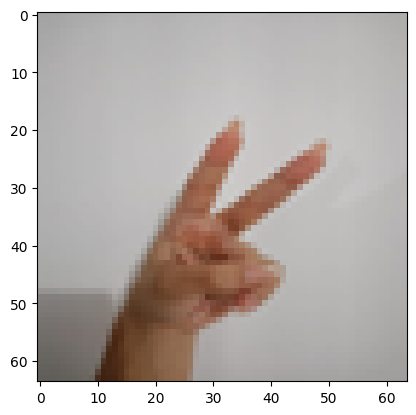

In [ ]:
from PIL import Image

basewidth = 300
img = Image.open('doisJocy.jpeg')
img = img.resize((64, 64))
resized = np.array(img)
plt.imshow(resized)
resized = np.expand_dims(resized, axis=0)    # transformando a imagem em um tensor

predictions = model.predict(resized)         # rede realizando a prediçao após o aprendizado
print((predictions.T))                         # imprimindo a saída softmax da rede